### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

### Read the test and train dataset from the checkpoint

In [2]:
train_df = pd.read_csv("../data/final_train_dataset_w56types.csv")

In [3]:
train_df.shape

(7217, 9)

## Data Preprocessing

In [4]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_id                        7217
project_name                      7152
methodology                        272
region                              14
voluntary_registry                   4
project_type_from_the_registry      96
project_developer                 2503
arb_wa_project                       4
project_type                        56
dtype: int64


### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [6]:

type_df = train_df["project_type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["project_type", 'count']

type_counts


,project_type,count
0,Cookstoves,1147
1,Wind,811
2,Improved Forest Management,605
3,Hydropower,423
4,Afforestation/Reforestation,380
5,Manure Methane Digester,360
6,Clean Water,330
7,Landfill Methane,306
8,Solar - Centralized,263
9,Rice Emission Reductions,234


In [ ]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [7]:
X_train_df = train_df.drop(columns=['project_type'])
Y_train_df = train_df['project_type']

In [8]:
print(X_train_df.shape)

(7217, 8)


In [9]:
## Splitting the train to train and validation sets
X_train_1, X_val_1, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train_1.shape, X_val_1.shape, Y_train.shape, Y_val.shape )

(6495, 8) (722, 8) (6495,) (722,)


In [10]:
X_train = X_train_1.drop(columns=['project_id'])
X_val = X_val_1.drop(columns=['project_id'])


## Encoding the categorical and text features


In [11]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arb_wa_project']
text_features = ['project_name','methodology','project_type_from_the_registry', 'project_developer']


In [12]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = RandomOverSampler(random_state=42)
sampling_strategy = {
    'Cookstoves': 800
}
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [13]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(44800, 11600) (44800,)
float64


In [14]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

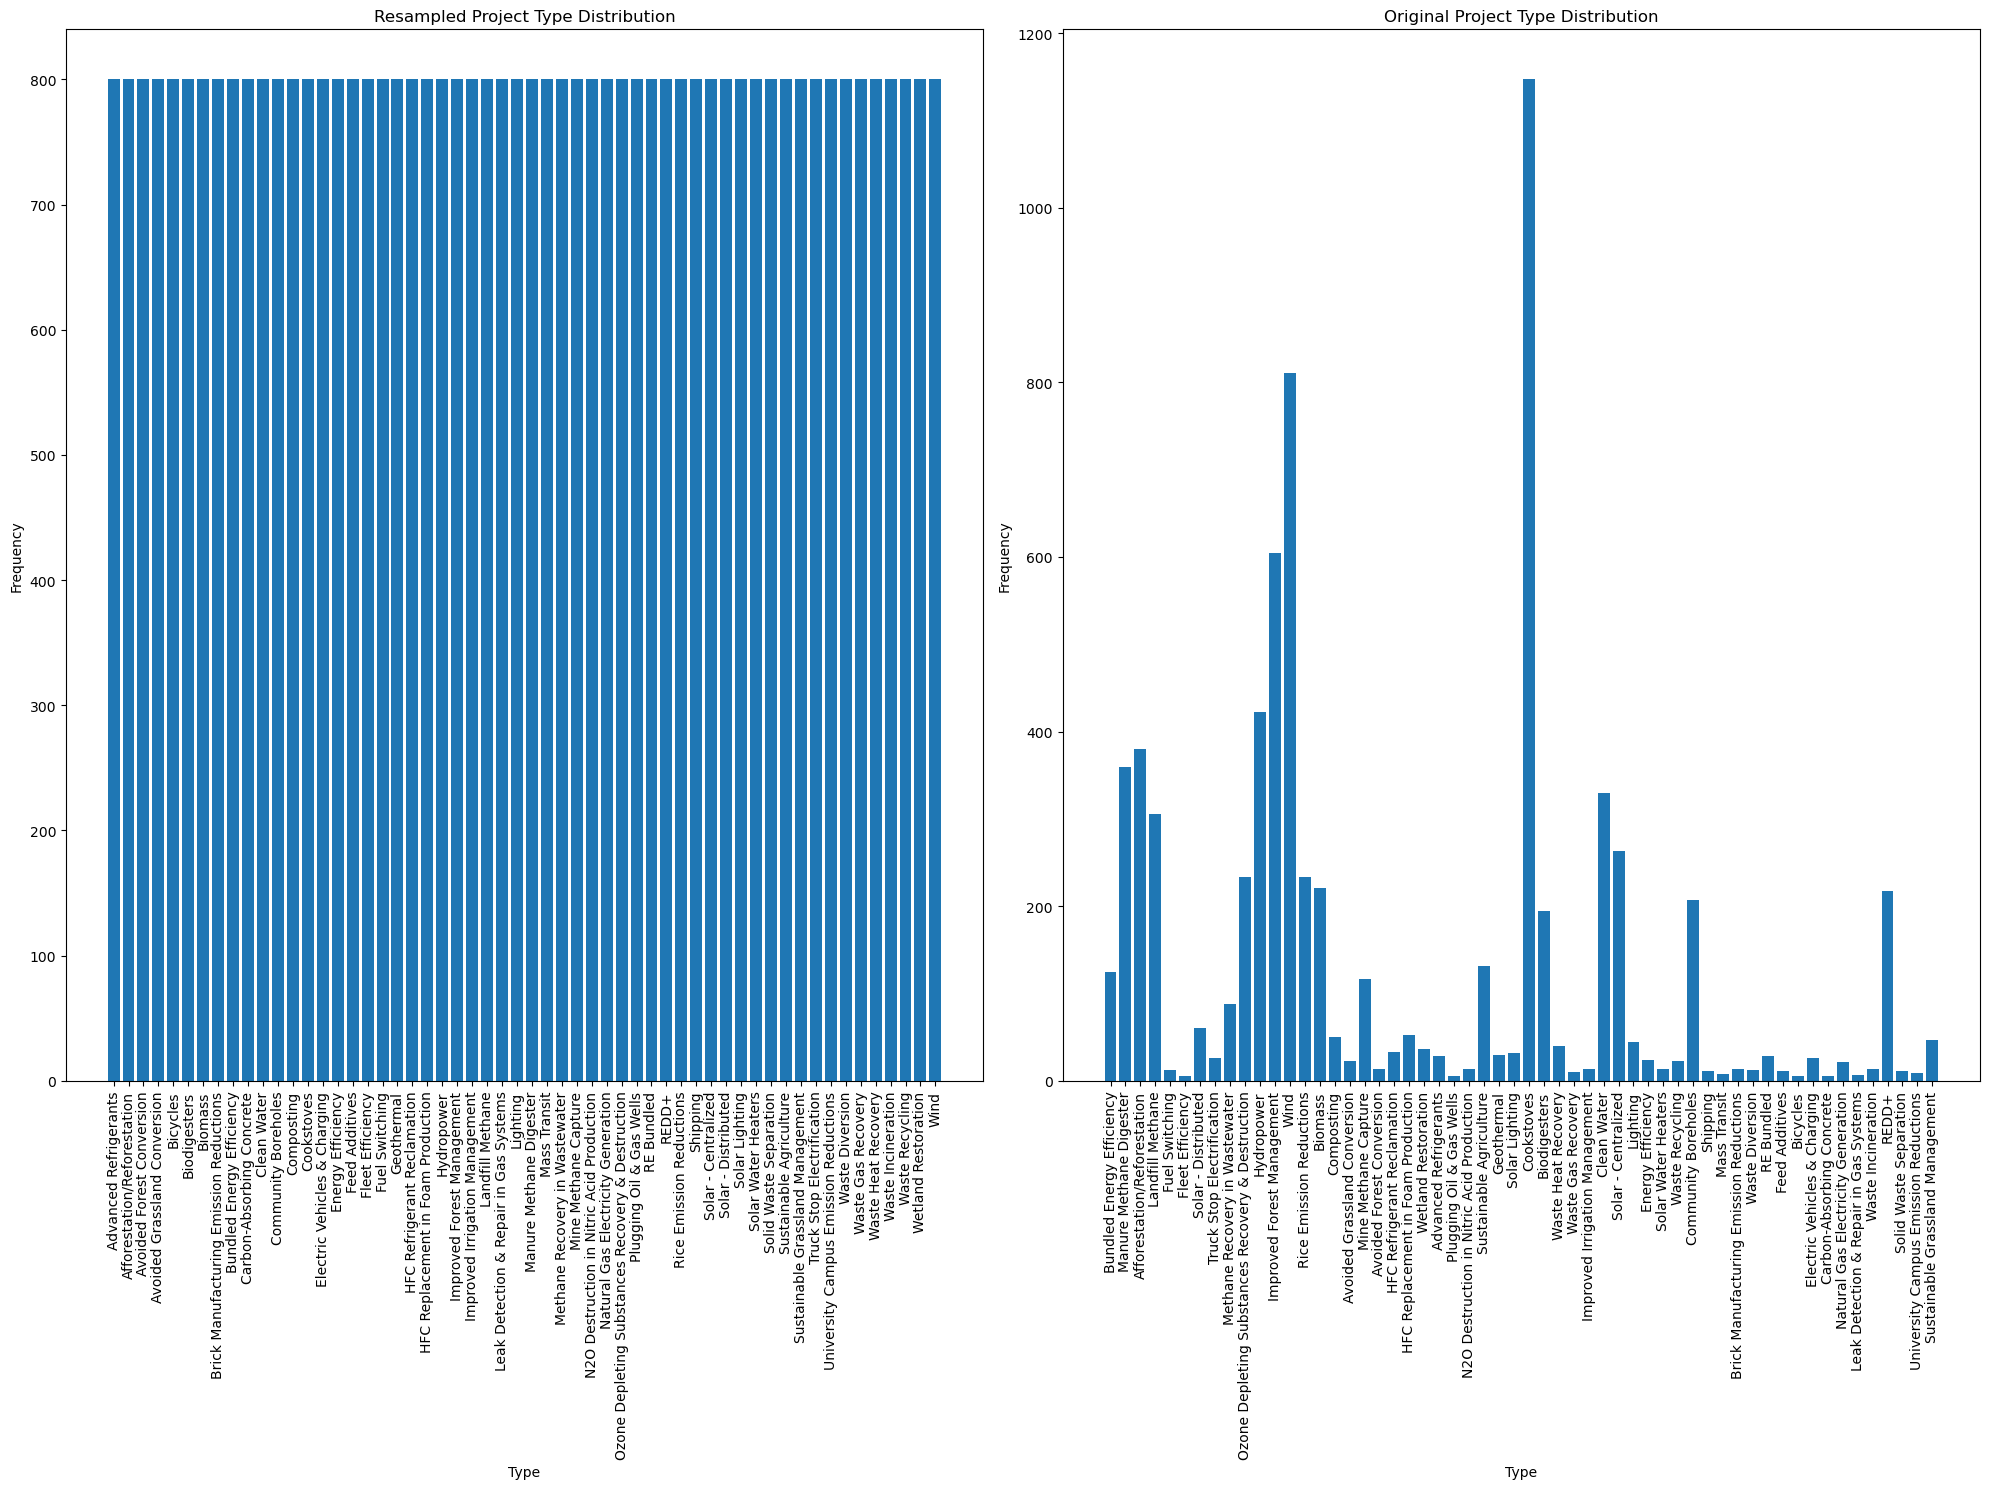

In [15]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [16]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)



LogisticRegression(max_iter=1000, random_state=42)

In [17]:
## Save the model and processor with Joblib

joblib.dump(preprocessor, '../data/models/tfidf_onehotencoding_56types.pkl')

# Save the Logistic Regression model
joblib.dump(logistic_regression, '../data/models/logistic_regression_model_56types.pkl')

['../data/models/logistic_regression_model_56types.pkl']

In [18]:
# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Get the predicted probabilities for each class
y_pred_proba = logistic_regression.predict_proba(X_val_transformed)
# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,0.974359,1.000000,0.987013,38.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.000000
Bicycles,1.000000,1.000000,1.000000,1.000000
Biodigesters,0.947368,0.900000,0.923077,20.000000
Biomass,0.826087,0.863636,0.844444,22.000000
Brick Manufacturing Emission Reductions,1.000000,1.000000,1.000000,1.000000
Bundled Energy Efficiency,0.833333,0.769231,0.800000,13.000000
Carbon-Absorbing Concrete,1.000000,1.000000,1.000000,1.000000


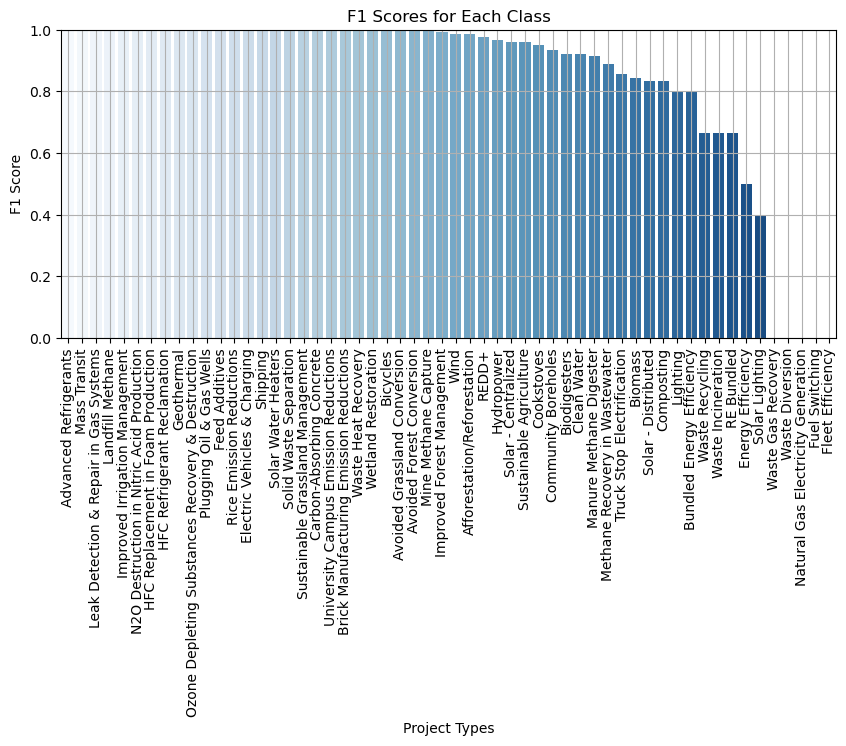

In [19]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Project Types')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

In [ ]:
## Check all the incorrect predictions

In [21]:
# Create a DataFrame to compare true labels and predictions
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})

# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)

# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id

# Display the DataFrame with incorrect predictions
incorrect_predictions = comparison_df[~comparison_df['Correct Prediction']]
print(incorrect_predictions.shape)
incorrect_predictions

(39, 12)


,project_name,methodology,region,voluntary_registry,project_type_from_the_registry,project_developer,arb_wa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id
10,Xiaoshan Power Plant's NG Power Generation Pro...,ACM0002 Grid-connected electricity generation ...,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,"Zhejiang Southeast Electric Power Co., Ltd.",No,Natural Gas Electricity Generation,Hydropower,0.343125,False,VCS432
45,Programme of Activities for Small Scale Solar ...,AMS-I.D. Grid connected renewable electricity ...,Southern Asia,GS,Other,Koho Trading and Consultancy (Private) Limited,No,RE Bundled,Solar - Centralized,0.431600,False,GS11416
86,LKPPL Fuel Switch Project for Generation of Cl...,ACM0011 Fuel switching from coal and/or petrol...,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Lanco Kondapalli Power Private Limited,No,Natural Gas Electricity Generation,Fuel Switching,0.313211,False,VCS620
144,Hubei Longshen Composting Project,AMS-III.D. Methane recovery in animal manure m...,Eastern Asia,VCS,"Livestock, enteric fermentation, and manure ma...","Hubei Longshen fertilizer Co., Ltd",No,Manure Methane Digester,Composting,0.759090,False,VCS4605
154,UpEnergy-Social and Climate Impact Programme- ...,GS TPDDTEC Reduced emissions from cooking and ...,Southern Asia,GS,Energy Efficiency - Domestic,UpEnergy Group,No,Clean Water,Cookstoves,0.376630,False,GS11008
175,GS12204 RVPA-1 Sistema.bio Global Carbon Progr...,GS methodology For Animal Waste Managment And ...,Sub-Saharan Africa,GS,Biogas - Heat,Sistema.bio Inc.,No,Manure Methane Digester,Biodigesters,0.691478,False,GS12078
182,GS 1366 Micro Energy PoA,GS TPDDTEC Reduced emissions from cooking and ...,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,CO2balance UK ltd,No,Cookstoves,Community Boreholes,0.451395,False,GS1366
191,Saihanba North 45.05 MW Windfarm Project,ACM0002 Grid-connected electricity generation ...,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,JPMorgan Ventures Energy Corporation,No,Wind,Hydropower,0.388751,False,VCS121
231,Biogas utilization project in Zhejiang Jingxin...,AMS-I.F. Renewable electricity generation for ...,Eastern Asia,GS,Biogas - Electricity,Swiss Carbon Assets Ltd.,No,Methane Recovery in Wastewater,Manure Methane Digester,0.238154,False,GS869
260,Renewable Energy based power generation projec...,ACM0002 Grid-connected electricity generation ...,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Solar - Centralized,RE Bundled,0.910439,False,VCS2263


In [ ]:
## Confidence level of the result

In [22]:
# Create a DataFrame to compare true labels and predictions with confidence levels
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})
# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)

# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id

correct_predictions = comparison_df[comparison_df['Correct Prediction']]
correct_predictions

,project_name,methodology,region,voluntary_registry,project_type_from_the_registry,project_developer,arb_wa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id
0,Pawan Urja Vistaran: Small entities combined w...,ACM0002 Grid-connected electricity generation ...,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Wind,Wind,0.826640,True,VCS741
1,Energy Efficient Cook Stove Implementation in ...,VMR0006 Energy Efficiency and Fuel Switch Meas...,Southern Asia,VCS,Energy demand,Enen Green Services Private Limited,No,Cookstoves,Cookstoves,0.963280,True,VCS2336
2,Mani 14 MW Small Hydropower Project,AMS-I.D. Grid connected renewable electricity ...,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,JPMorgan Ventures Energy Corporation,No,Hydropower,Hydropower,0.976930,True,VCS110
3,Haikou Rural Methane Digesters Project in Hain...,AMS-I.C. Thermal energy production with or wit...,Eastern Asia,GS,Biogas - Heat,Guizhou Honor Carbon Asset Management Co. Ltd,No,Biodigesters,Biodigesters,0.985896,True,GS2664
4,VPA 81 - GHG Emission Reduction through use of...,GS Simplified Methodology for Clean and Effici...,Southern Asia,GS,Energy Efficiency - Domestic,Bangladesh Bondhu Foundation,No,Cookstoves,Cookstoves,0.995578,True,GS11778
...,...,...,...,...,...,...,...,...,...,...,...,...
716,Distribution of Improved cook stove - Phase IV,AMS-II.G. Energy efficiency measures in therma...,Southern Asia,VCS,Energy demand,G K Energy Marketers Pvt. Ltd,No,Cookstoves,Cookstoves,0.974090,True,VCS2425
717,Consórcio Horizonte Asja,ACM0001 Flaring or use of landfill gas,Latin America and the Caribbean,GS,Biogas - Electricity,Consórcio Horizonte Asja,No,Landfill Methane,Landfill Methane,0.941965,True,GS3122
718,Nam Ngan Hydropower project,AMS-I.D. Grid connected renewable electricity ...,South-Eastern Asia,GS,"Small, Low - Impact Hydro",Swiss Carbon Value Ltd.,No,Hydropower,Hydropower,0.997261,True,GS3016
719,GS1247 VPA 74 Lango Safe Water Project,GS TPDDTEC Reduced emissions from cooking and ...,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,CO2balance UK ltd,No,Community Boreholes,Community Boreholes,0.695739,True,GS5188


In [ ]:
# Filter rows where 'rule_based_type_mapping_first' is not empty or only spaces and equals True Label
rulebased_df = comparison_df[
    (comparison_df['rule-based_type_mapping_first'].str.strip() != '') &
    (comparison_df['rule-based_type_mapping_first'] == comparison_df['True Label'].astype(str)) #&
]
rulebased_df

In [ ]:
#Incorrect rule based predictions
# Filter rows where 'rule_based_type_mapping_first' is not empty or only spaces and equals True Label
rulebased_df_false = comparison_df[
    (comparison_df['rule-based_type_mapping_first'].str.strip() != '') &
    (comparison_df['rule-based_type_mapping_first'] != comparison_df['True Label'].astype(str)) #&
   # (comparison_df['rule_based_type_mapping_first'] == comparison_df['True Label'].astype(str))
]
print(rulebased_df_false.shape)
rulebased_df_false